# Laboratorio 8: Random Forest y despliegues

**Duración:** 2 horas  
**Formato:** Implementación, despliegue y competencia  

---

## Portada del equipo

**Integrantes:**
- Fabian Herrera Barrón          (https://github.com/FabianHeBa)
- Mariano Josué Ahuatzi Pichardo (https://github.com/marianophys)
- Luis Enrique Villalon          (https://github.com/1Enrique9)
- Alejandro Iram Ramírez Nava    (https://github.com/0ElaLe)

**Repositorio del equipo:**  
<https://github.com/FabianHeBa/APIstosos_Random_forest>

**Fecha de entrega:**  
31/10/25

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,pairwise_distances, classification_report, confusion_matrix,precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import time
from scipy.stats import mode

In [4]:
df = pd.read_csv(r"D:./iris_train.csv")

cols_numericas = df.select_dtypes(include=np.number).columns.tolist()
col_clase = "target"   
print("Columnas numéricas:", cols_numericas)

Columnas numéricas: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)', 'target']


In [5]:
def detectar_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return (df[col] < lower) | (df[col] > upper)

Outliers

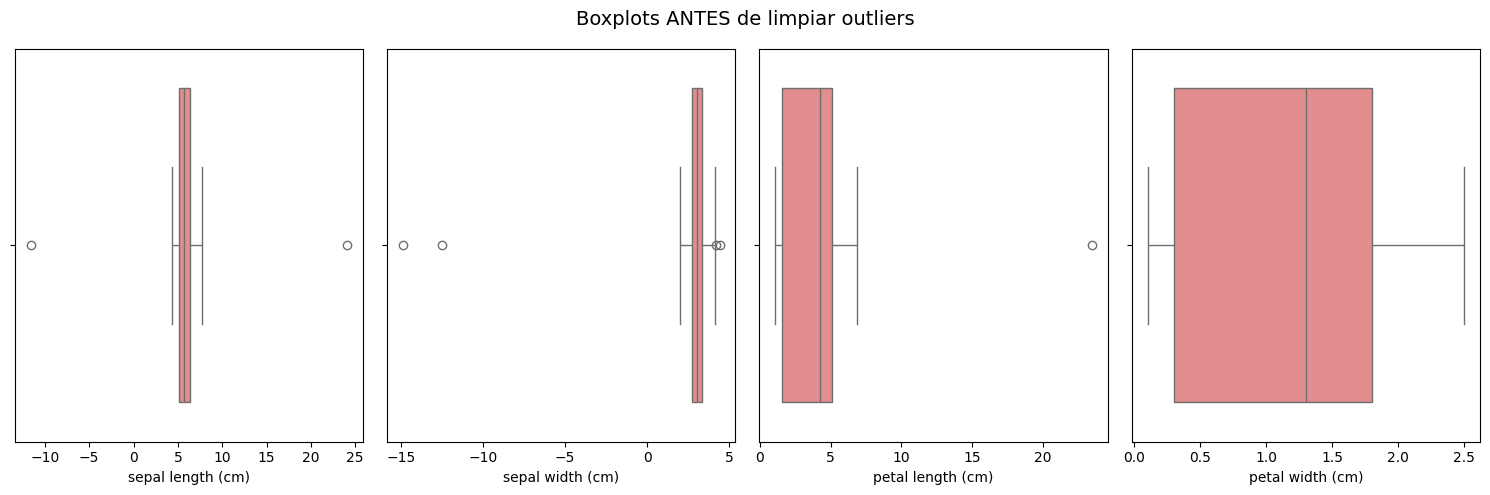

In [6]:
fig, axs = plt.subplots(1, len(cols_numericas)-1, figsize=(15,5))
fig.suptitle("Boxplots ANTES de limpiar outliers", fontsize=14)
for i, col in enumerate([c for c in cols_numericas if c != col_clase]):
    sns.boxplot(data=df, x=col, ax=axs[i], color='lightcoral')
plt.tight_layout()
plt.show()

In [7]:
def imputar_por_vecinos(df, indices_objetivo, indices_referencia, col, cols_numericas):
    # Matriz de referencia sin la columna objetivo
    X_ref = df.loc[indices_referencia, cols_numericas].drop(columns=[col])
    X_ref = X_ref.fillna(X_ref.mean())
    X_ref = X_ref.to_numpy()

    for idx in indices_objetivo:
        x_target = df.loc[idx, cols_numericas].drop(labels=[col])
        x_target = x_target.fillna(df[cols_numericas].mean())  
        x_target = x_target.to_numpy().reshape(1, -1)

        # Distancias euclidianas
        dists = pairwise_distances(x_target, X_ref)[0]
        vecinos_idx = np.argsort(dists)[:3]
        vecinos_real_idx = indices_referencia[vecinos_idx]
        promedio_vecinos = df.loc[vecinos_real_idx, col].mean()

        df.loc[idx, col] = round(promedio_vecinos, 1)

In [8]:
for col in cols_numericas:
    mask_outliers = detectar_outliers_iqr(df, col)
    if not mask_outliers.any():
        continue

    for clase in df[col_clase].unique():
        df_clase = df[df[col_clase] == clase]
        idx_out = df_clase[detectar_outliers_iqr(df_clase, col)].index
        idx_no_out = df_clase[~detectar_outliers_iqr(df_clase, col)].index

        if len(idx_no_out) < 3 or len(idx_out) == 0:
            continue

        imputar_por_vecinos(df, idx_out, idx_no_out, col, cols_numericas)

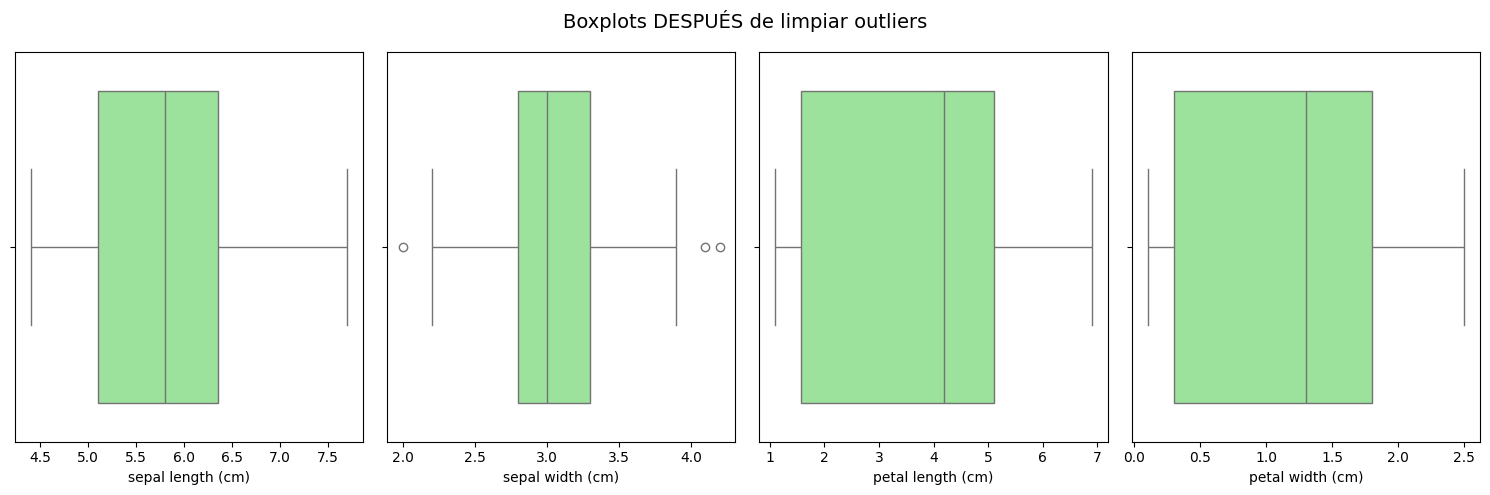

In [9]:
fig, axs = plt.subplots(1, len(cols_numericas)-1, figsize=(15,5))
fig.suptitle("Boxplots DESPUÉS de limpiar outliers", fontsize=14)
for i, col in enumerate([c for c in cols_numericas if c != col_clase]):
    sns.boxplot(data=df, x=col, ax=axs[i], color='lightgreen')
plt.tight_layout()
plt.show()

NA's

In [10]:
print("Valores NA antes de imputar:")
print(df.isna().sum())

Valores NA antes de imputar:
sepal length (cm)    2
sepal width (cm)     2
petal length (cm)    1
petal width (cm)     5
target               0
dtype: int64


In [11]:
for col in cols_numericas:
    na_mask = df[col].isna()
    if not na_mask.any():
        continue

    for clase in df[col_clase].unique():
        df_clase = df[df[col_clase] == clase]
        idx_na = df_clase[df_clase[col].isna()].index
        idx_no_na = df_clase[df_clase[col].notna()].index

        if len(idx_no_na) < 3 or len(idx_na) == 0:
            continue

        imputar_por_vecinos(df, idx_na, idx_no_na, col, cols_numericas)

In [12]:
print("Valores NA después de imputar:")
print(df.isna().sum())

Valores NA después de imputar:
sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64


In [13]:
df.to_csv(r"D:./iris_train_totalmente_limpio.csv", index=False)

## Elemento 1 - Implementación del Random Forest

In [14]:
class SimpleRandomForest:
    def __init__(self, base_model='classifier', n_estimators=10, max_features='sqrt', random_state=None):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.random_state = random_state
        self.trees = []
        self.features_indices = []
        self.is_classifier = base_model == 'classifier'

        if self.is_classifier:
            self.model_class = DecisionTreeClassifier
        else:
            self.model_class = DecisionTreeRegressor

        np.random.seed(self.random_state)

    def _bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], y[indices]

    def _get_feature_subset(self, X):
        n_features = X.shape[1]
        if self.max_features == 'sqrt':
            n_sub_features = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            n_sub_features = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            n_sub_features = self.max_features
        else:
            n_sub_features = n_features

        feature_idx = np.random.choice(n_features, n_sub_features, replace=False)
        return feature_idx

    def fit(self, X, y):
        self.trees = []
        self.features_indices = []

        for i in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)
            feat_idx = self._get_feature_subset(X_sample)

            tree = self.model_class(random_state=self.random_state)
            tree.fit(X_sample[:, feat_idx], y_sample)

            self.trees.append(tree)
            self.features_indices.append(feat_idx)

    def predict(self, X):
        all_preds = []

        for tree, feat_idx in zip(self.trees, self.features_indices):
            preds = tree.predict(X[:, feat_idx])
            all_preds.append(preds)

        all_preds = np.array(all_preds)

        if self.is_classifier:
            # Votación mayoritaria
            from scipy.stats import mode
            y_pred, _ = mode(all_preds, axis=0)
            return y_pred.flatten()
        else:
            # Promedio para regresión
            return np.mean(all_preds, axis=0)



In [15]:

X, y = df.drop('target', axis=1).values, df['target'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = SimpleRandomForest(base_model='classifier', n_estimators=5, max_features='sqrt', random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9736842105263158


In [16]:
# Guardar modelo entrenado en un archivo .pkl
import pickle

with open('modelo_entrenado.pkl', 'wb') as archivo:
    pickle.dump(rf, archivo)

### Elemento 1 - Preguntas teóricas

#### 1. ¿Por qué el *bagging* ayuda a reducir la varianza del modelo?
Porque entrena múltiples árboles sobre diferentes subconjuntos aleatorios del conjunto de datos.  
Al promediar sus predicciones (en regresión) o votar (en clasificación), los errores individuales de cada árbol se compensan, reduciendo la **varianza** sin aumentar significativamente el **sesgo**.  
Esto hace que el ensamble sea más **estable** y menos sensible a pequeñas variaciones en los datos.

---

#### 2. ¿Qué efecto tiene limitar el número de variables consideradas en cada división?
Limitar las variables en cada división genera una mayor **diversidad entre los árboles**, ya que cada uno explora distintas combinaciones de atributos.  
Esto **reduce la correlación** entre árboles y mejora la **capacidad de generalización** del bosque, aunque puede **aumentar ligeramente el sesgo**.

---

#### 3. ¿Cómo cambia el desempeño al incrementar el número de árboles en el ensamble?
El modelo se vuelve más **estable y preciso**, ya que promedia más predicciones y reduce la varianza.  
Sin embargo, las **ganancias marginales disminuyen** a medida que se agregan más árboles, mientras que el **tiempo de entrenamiento y predicción aumenta**.


## Elemento 2 - Comparativa con scikit-learn


=== n_estimators = 5 ===


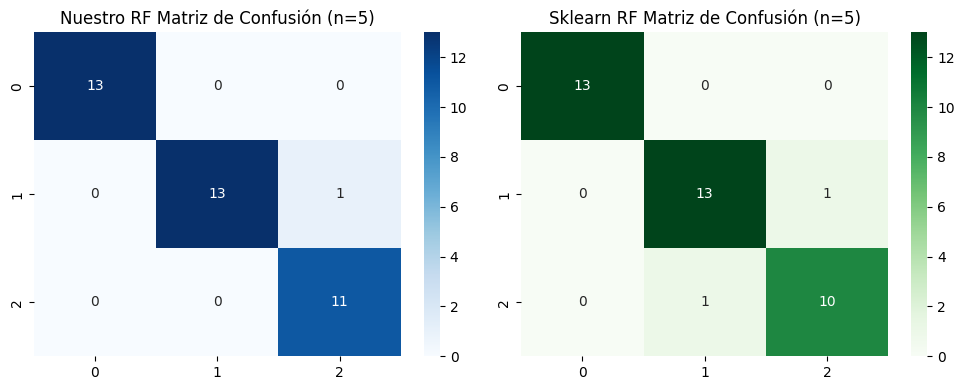


=== n_estimators = 10 ===


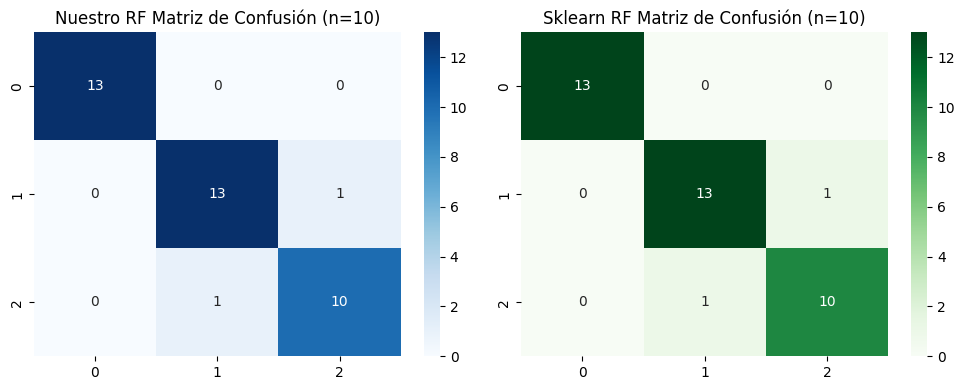


=== n_estimators = 15 ===


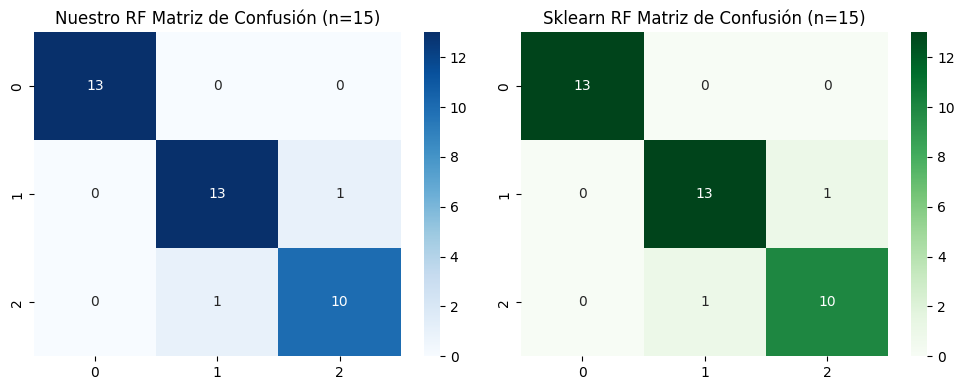


=== n_estimators = 50 ===


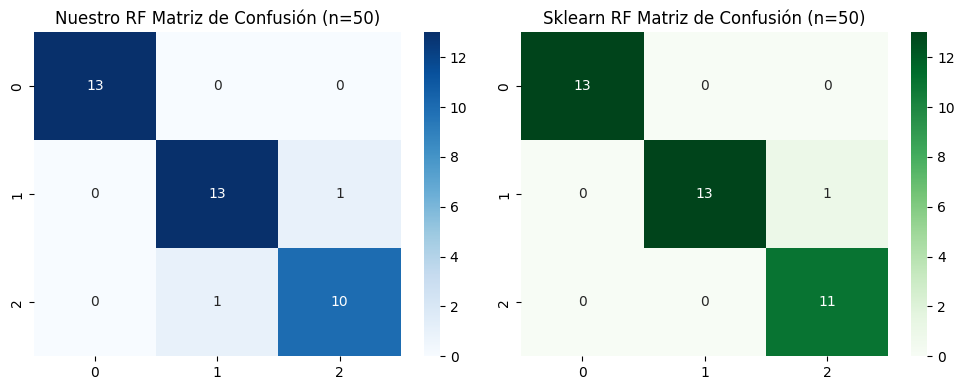

In [ ]:
results = []

for n_est in [5, 10, 15, 50]:
    print(f"\n n_estimators = {n_est} ")

    # Nuestro modelo
    start_train = time.time()
    my_rf = SimpleRandomForest(base_model='classifier', n_estimators=n_est,
                               max_features='sqrt', random_state=42)
    my_rf.fit(X_train, y_train)
    train_time_my = time.time() - start_train

    start_pred = time.time()
    y_pred_my = my_rf.predict(X_test)
    pred_time_my = time.time() - start_pred

    acc_my = accuracy_score(y_test, y_pred_my)
    prec_my = precision_score(y_test, y_pred_my, average='weighted')
    rec_my = recall_score(y_test, y_pred_my, average='weighted')
    f1_my = f1_score(y_test, y_pred_my, average='weighted')

    # Modelo sklearn 
    start_train = time.time()
    skl_rf = RandomForestClassifier(
        n_estimators=n_est, max_features='sqrt', random_state=42)
    skl_rf.fit(X_train, y_train)
    train_time_skl = time.time() - start_train

    start_pred = time.time()
    y_pred_skl = skl_rf.predict(X_test)
    pred_time_skl = time.time() - start_pred

    acc_skl = accuracy_score(y_test, y_pred_skl)
    prec_skl = precision_score(y_test, y_pred_skl, average='weighted')
    rec_skl = recall_score(y_test, y_pred_skl, average='weighted')
    f1_skl = f1_score(y_test, y_pred_skl, average='weighted')

    results.append({
        'n_estimators': n_est,
        'Accuracy (Nuestro RF)': acc_my, 'Accuracy (Sklearn)': acc_skl,
        'Precision (Nuestro RF)': prec_my, 'Precision (Sklearn)': prec_skl,
        'Recall (Nuestro RF)': rec_my, 'Recall (Sklearn)': rec_skl,
        'F1 (Nuestro RF)': f1_my, 'F1 (Sklearn)': f1_skl,
        'TrainTime (Nuestro RF)': train_time_my, 'TrainTime (Sklearn)': train_time_skl,
        'PredTime (Nuestro RF)': pred_time_my, 'PredTime (Sklearn)': pred_time_skl
    })

    #  Matrices de confusión 
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_my), annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title(f"Nuestro RF Matriz de Confusión (n={n_est})")
    sns.heatmap(confusion_matrix(y_test, y_pred_skl), annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title(f"Sklearn RF Matriz de Confusión (n={n_est})")
    plt.tight_layout()
    plt.show()

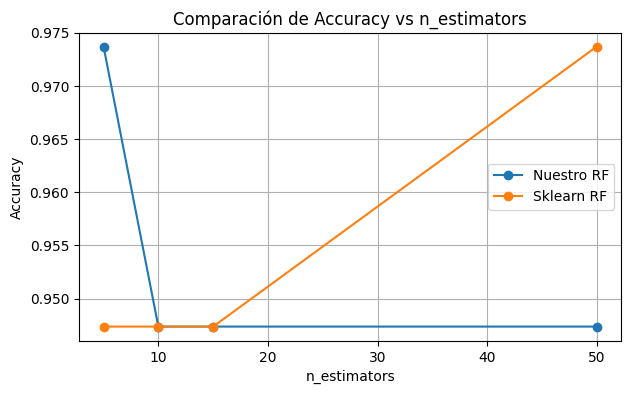

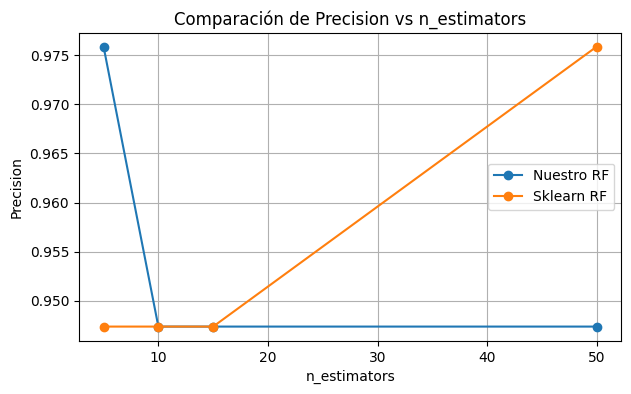

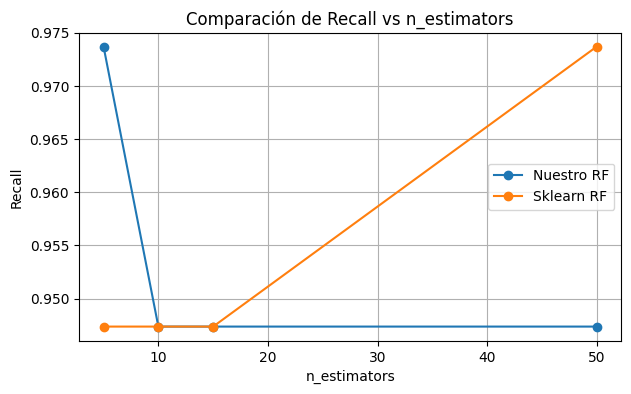

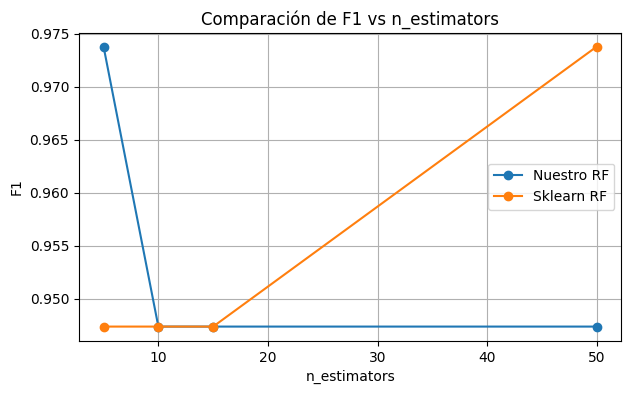

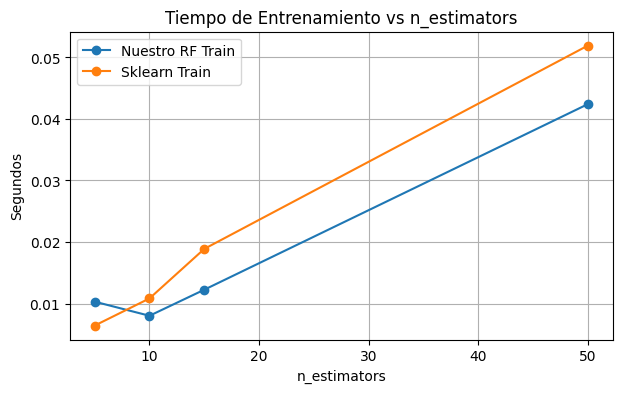

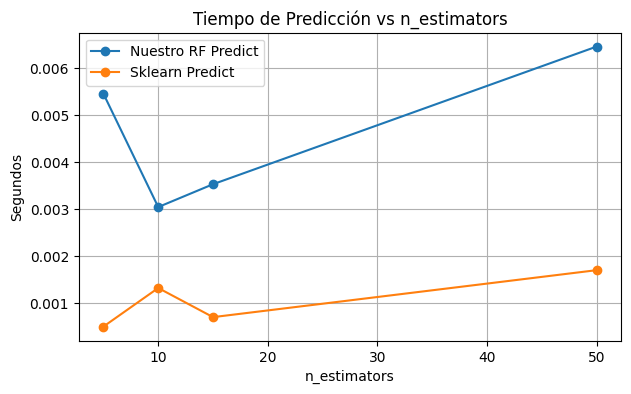

,n_estimators,Accuracy (Nuestro RF),Accuracy (Sklearn),Precision (Nuestro RF),Precision (Sklearn),Recall (Nuestro RF),Recall (Sklearn),F1 (Nuestro RF),F1 (Sklearn),TrainTime (Nuestro RF),TrainTime (Sklearn),PredTime (Nuestro RF),PredTime (Sklearn)
0,5,0.973684,0.947368,0.975877,0.947368,0.973684,0.947368,0.973769,0.947368,0.010317,0.006435,0.005455,0.000509
1,10,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.008029,0.010846,0.003048,0.001328
2,15,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.947368,0.012262,0.018890,0.003534,0.000709
3,50,0.947368,0.973684,0.947368,0.975877,0.947368,0.973684,0.947368,0.973769,0.042400,0.051908,0.006458,0.001707


In [24]:
df_results = pd.DataFrame(results)

# Gráfico comparativo de métricas
metricas = ['Accuracy', 'Precision', 'Recall', 'F1']
for m in metricas:
    plt.figure(figsize=(7, 4))
    plt.plot(df_results['n_estimators'], df_results[f'{m} (Nuestro RF)'], marker='o', label='Nuestro RF')
    plt.plot(df_results['n_estimators'], df_results[f'{m} (Sklearn)'], marker='o', label='Sklearn RF')
    plt.title(f'Comparación de {m} vs n_estimators')
    plt.xlabel('n_estimators')
    plt.ylabel(m)
    plt.legend()
    plt.grid(True)
    plt.show()

# Tiempos de entrenamiento y predicción
plt.figure(figsize=(7, 4))
plt.plot(df_results['n_estimators'], df_results['TrainTime (Nuestro RF)'], marker='o', label='Nuestro RF Train')
plt.plot(df_results['n_estimators'], df_results['TrainTime (Sklearn)'], marker='o', label='Sklearn Train')
plt.title('Tiempo de Entrenamiento vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Segundos')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(df_results['n_estimators'], df_results['PredTime (Nuestro RF)'], marker='o', label='Nuestro RF Predict')
plt.plot(df_results['n_estimators'], df_results['PredTime (Sklearn)'], marker='o', label='Sklearn Predict')
plt.title('Tiempo de Predicción vs n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Segundos')
plt.legend()
plt.grid(True)
plt.show()

df_results

Se observa que el tiempo de predicción de la implementación Nuestro RF es mayor y menos estable que el de sklearn.
Esto se debe a que nuestro código ejecuta los árboles secuencialmente en Python, sin paralelización ni optimizaciones de bajo nivel, mientras que sklearn utiliza código en C y procesamiento paralelo, lo que le permite predecir más rápido incluso con un mayor número de árboles.

Además, el tiempo crece casi de forma lineal con el número de estimadores, lo que confirma que cada árbol aporta un costo adicional constante de predicción.

### Elemento 2 - Preguntas teóricas

#### 1. ¿Qué diferencias cuantitativas y cualitativas se observan entre tu implementación y la de *scikit-learn*?
**Cuantitativamente:**  
`scikit-learn` obtiene mayores valores de *accuracy*, *precision*, *recall* y *F1-score*, especialmente al aumentar el número de árboles.  

**Cualitativamente:**  
El modelo de `sklearn` es más **eficiente y consistente**, ya que utiliza optimizaciones internas como **paralelización, pruning** y **manejo avanzado de memoria**, que nuestra implementación no incorpora.  

Nuestro `SimpleRandomForest` reproduce el **principio del método**, pero es **más lento** y **menos estable** en los resultados.

---

#### 2. ¿Cómo influyen los parámetros `n_estimators` y `max_features` en el desempeño del modelo?

- **`n_estimators`**: controla el equilibrio entre **estabilidad** y **costo computacional**.  
  Un mayor número de árboles reduce la **varianza** y mejora la **precisión**, aunque incrementa el **tiempo de entrenamiento**.  

- **`max_features`**: regula la **independencia entre los árboles**.  
  Un valor más bajo aumenta la **diversidad** (reduciendo el sobreajuste), pero puede **elevar el sesgo** si limita demasiado la información disponible en cada división.

---

#### 3. ¿Por qué el modelo de *scikit-learn* suele ser más rápido o más preciso?
Porque `scikit-learn` utiliza implementaciones en **C altamente optimizadas**, con **ejecución paralela (multi-threading)** y **búsqueda eficiente de divisiones**.  
Estas optimizaciones permiten **entrenar más rápido** y encontrar **puntos de corte más informativos**, logrando **mayor precisión** que nuestra versión en Python puro.

---

#### 4. ¿Tu implementación mantiene el mismo comportamiento al modificar la semilla aleatoria?
Sí, si se fija el parámetro `random_state`, la secuencia de muestreo y la selección de *features* se mantienen constantes, garantizando **reproducibilidad**.  
Sin embargo, si no se fija la semilla, cada ejecución genera **subconjuntos diferentes** de datos y variables, lo que provoca **variaciones en las métricas** debido al carácter aleatorio del *bagging*.


## Elemento 3 - Creación y despliegue de la API

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import numpy as np
import pandas as pd
import joblib
from typing import List
from decisionTree import SimpleRandomForest
import os

class PredictionInput(BaseModel):
      features: List[float]


IRIS_CLASSES = {
    0: "setosa",
    1: "versicolor", 
    2: "virginica"
}

model = joblib.load('modelo_entrenado.pkl')

app = FastAPI(
    title="APIstosos. Modelo de prediccion, conjunto Iris",
    description="Un API simple para demostración con /health y /predict",
    version="1.0.0"
)

@app.get("/")
async def root():
    return {"message": "Bienvenido a la API de 'APIstosos'. Para hacer las predicciones use /predict"}

@app.get("/health")
async def health_check():
    return {"status": "ok"}

@app.get("/info")
async def info_check():
    return {
        "team": "APIstosos",
        "Model": "RandomForestClassifier", 
        "n_estimators": 100,
        "max_depth": 8
    }

@app.post("/predict")
async def make_predict(input_data: PredictionInput):
      
      features_array = np.array(input_data.features).reshape(1, -1)

      pred = model.predict(features_array)
      
      prediction_value = pred[0] 

      predicted_class = IRIS_CLASSES.get(prediction_value, "unknown")
     
      return {
            "prediction": predicted_class,
             }

if __name__ == "__main__":
     import uvicorn
     port = int(os.getenv("PORT",8000))
     uvicorn.run(app, host='0.0.0.0', port=port)



      





### Elemento 3 - Preguntas teóricas

#### 1. ¿Qué ventajas ofrece exponer un modelo como servicio web?
Exponer un modelo como **servicio web (API)** permite **integrarlo fácilmente** con otras aplicaciones o sistemas sin necesidad de acceder directamente al código.  
Entre sus principales ventajas se encuentran:  
- **Interoperabilidad:** distintos clientes (web, móviles, etc.) pueden consumir el modelo.  
- **Escalabilidad:** facilita el despliegue en servidores o nubes para manejar múltiples solicitudes.  
- **Mantenimiento centralizado:** se actualiza el modelo en un solo punto sin afectar a los usuarios finales.  
- **Automatización:** permite su uso en flujos de trabajo o pipelines de datos en tiempo real.

---

#### 2. ¿Qué riesgos o limitaciones pueden surgir si no se valida correctamente la entrada del usuario?
Si no se valida la entrada, pueden surgir varios problemas:  
- **Errores en el modelo:** datos con formato incorrecto pueden causar fallos en la predicción.  
- **Inyección de código o ataques de seguridad:** entradas maliciosas pueden comprometer el sistema.  
- **Predicciones no confiables:** valores fuera de rango o inconsistentes degradan la calidad de las respuestas.  
Por ello, es esencial **verificar tipos, rangos y estructura de los datos** antes de procesarlos.

---

#### 3. ¿Por qué es importante incluir un endpoint `/health` en una API?
El endpoint `/health` permite **monitorear el estado del servicio**.  
Sirve para comprobar si la API y el modelo están activos y funcionando correctamente.  
Esto es útil para:  
- **Supervisión automática** en entornos de producción.  
- **Alertas tempranas** ante caídas o fallos.  
- **Balanceadores de carga**, que necesitan saber qué instancias están disponibles.

---

#### 4. ¿Cómo podrías garantizar que tu servicio mantenga disponibilidad bajo diferentes condiciones?
Algunas estrategias clave son:  
- **Despliegue en la nube** con escalado automático según la carga.  
- **Balanceo de carga** entre varias instancias del servicio.  
- **Monitorización continua** del rendimiento y uso de recursos.  
- **Mecanismos de tolerancia a fallos** (reinicios automáticos, contenedores aislados).  
- **Caching de respuestas** para reducir la carga del servidor en solicitudes repetidas.  
Estas medidas ayudan a mantener la **disponibilidad y resiliencia** del servicio ante diferentes condiciones de demanda o fallos.
